# Analyze Census Data with AI

- Use psycopg2 to load the data from the database into Python. 
- Use SQL filter the data to minimize the data transfer. 
- Use pandas and matplotlib to rocess and visualize the loaded data.
- Use OpenAI to assist coding.

### Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Modify and Query Tables with Cursor

###  Insert data
Insert a fake state with fips = 100

In [3]:
fips = '100'
name = 'fake_state'

sql_insert = f""" insert into name(fips,name)
                    values('{fips}','{name}')"""
print(sql_insert)

 insert into name(fips,name)
                    values('100','fake_state')


In [4]:
cur.execute(sql_insert)

In [5]:
conn.commit()

### Query data
Find the fake state

In [6]:
sql_query = f"""select * from name where fips = '{fips}'"""


In [7]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


## Rollback
When errors occur, the cursor will be locked.

The following code will generate an error

In [8]:
cur.execute(sql_insert)

UniqueViolation: duplicate key value violates unique constraint "name_pkey"
DETAIL:  Key (fips)=(100) already exists.


And the cursor is now locked.

In [9]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


Unlock the cursor by using rollback

In [10]:
conn.rollback()

Cursor is now working

In [11]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


Delete the fake state

In [12]:
sql_delete = f"""
            delete from name
            where fips = '{fips}'
            """
print(sql_delete)


            delete from name
            where fips = '100'
            


In [13]:
cur.execute(sql_delete)

In [14]:
conn.commit()

The fake state is now deleted. 

In [15]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

## Simple Data Analytics

### Display the VA Income Data Over Time

Define the SQL command. We filter the data based on the ```fips``` as it is a primary key.

In [20]:
sql = """
     select * from name_income
     where fips = '51'
     """

Use pandas to load the data and display the top 5 rows

In [22]:
import pandas as pd

va_df = pd.read_sql(sql, con=conn)
va_df.head() #show the top 5 rows

/tmp/ipykernel_7971/4222419302.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  va_df = pd.read_sql(sql, con=conn)


,fips,name,income,year
0,51,Virginia,54240,2005
1,51,Virginia,56277,2006
2,51,Virginia,59562,2007
3,51,Virginia,61233,2008
4,51,Virginia,59330,2009


Use a line chart to show the VA income over years.

<Axes: xlabel='year'>

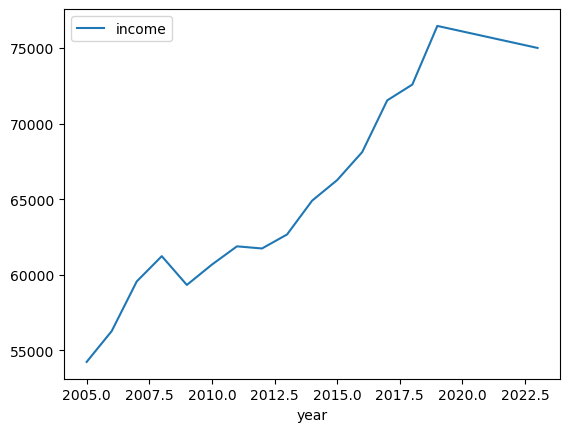

In [23]:
va_df.plot(x='year', y='income')

## Use AI to Assistant Data Analytics

### Install Python Packages

- jupyter-ai-magics: the JupyterLab AI to call Generative AI models

In [24]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.9 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [25]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [26]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands

In [27]:
%load_ext jupyter_ai_magics

Optional: Check the available AI models

`%ai list`

### Explain Existing Codes

In [28]:
%%ai gpt4
What is included in the {va_df}

The data provided includes the following variables:

- **fips**: This is a numerical code used for the statistical data collection of federal agencies in the United States. The number 51 stands for the state of Virginia.

- **name**: This refers to the name of the location represented by the fips code. In this case, it's Virginia.

- **income**: This signifies the median annual household income in Virginia for the corresponding year. The values are in US dollars.

- **year**: This represents the specific year in which the income data was recorded. The dataset spans from the year 2005 to 2023. 

Here's the above explanation in the form of a data frame:

| Variable | Description |
|:---------|:------------|
| fips | Numerical code representing the state of Virginia |
| name | Name of the location (Virginia) |
| income | Median annual household income in Virginia |
| year | The year in which the income data was recorded |

Optional: explain a code in a specific cell with cell number

`%%ai gpt4`

`explain the code in {In[#]} `

### Create New Codes with AI

In [29]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {va_df}, use the va_df directly, and visualize the result on a line chart

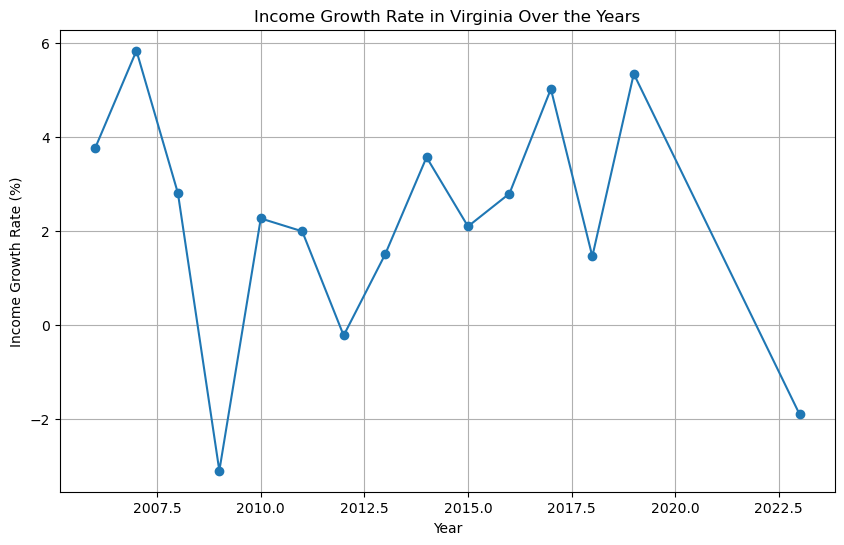

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# dataset given
data = {'fips': [51]*16, 'name': ['Virginia']*16, 
        'income': [54240, 56277, 59562, 61233, 59330, 60674, 61882, 61741, 62666, 64902, 66262, 68114, 71535, 72577, 76456, 75000], 
        'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2023]}

va_df = pd.DataFrame(data)

# calculate the growth rate
va_df['growth_rate'] = va_df['income'].pct_change() * 100

# Line chart
plt.figure(figsize=(10,6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('Income Growth Rate (%)')
plt.title('Income Growth Rate in Virginia Over the Years')
plt.grid(True)
plt.show()

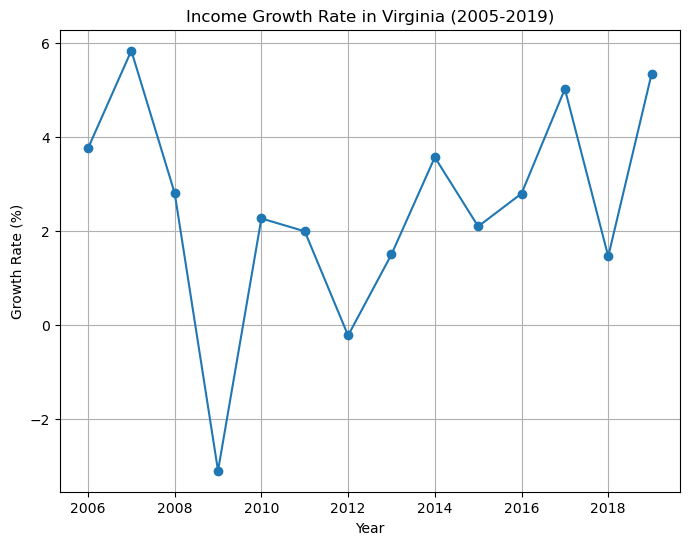

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataframe is named as va_df

va_df['growth_rate'] = va_df['income'].pct_change() * 100

plt.figure(figsize=(8, 6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

### A Complete Analysis with AI

Load the data from database into Python

In [31]:
%%ai gpt4 -f code
We have a view named name_income in an SQL database
You don't need to redefine the connection string
use the {conn} defined in {In[2]} to load all the recored into pandas dataframe 

In [32]:
import pandas as pd
import psycopg2

# Define the SQL query
sql_query = "SELECT * FROM name_income;"

# Use pandas to execute the SQL query and load the result into a DataFrame
df = pd.read_sql(sql_query, con=conn)

# Close the cursor and the connection
cur.close()
conn.close()


In [33]:
import pandas as pd

# Execute the SQL query
cur.execute("SELECT * FROM name_income")

# Fetch all the records
rows = cur.fetchall()

# Get the column names for the dataframe
column_names = [desc[0] for desc in cur.description]

# Create a pandas dataframe
df = pd.DataFrame(rows, columns=column_names)

df.head()

InterfaceError: cursor already closed

In [34]:
%%ai gpt4 
What is the information in {df}

The given DataFrame contains information about the income and year for different regions specified by their FIPS codes and names. There are four columns in the DataFrame: 

- `fips`: This is a string/numeric code which serves as a unique identifier for each region. It stands for Federal Information Processing Standards.

- `name`: This represents the name of the region represented by the corresponding FIPS code. It includes states like Alabama, Alaska, Arizona, Arkansas, California, West Virginia, Wisconsin, Wyoming, Puerto Rico, Virginia, and others.

- `income`: This represents the income for the corresponding region in the specified year. The income is given in monetary units (most likely US dollars).

- `year`: This represents the specific year for which the income data of the corresponding region is provided. The data includes records from years spanning 2005 to 2023.

In this Dataframe, there are 781 rows, which means there are 781 records each providing income data for a specific region in a certain year.

In [35]:
%%ai gpt4 -f code
Calculate the average year-over-year income growth rate for each state in {df} 
and create a chart to show the result

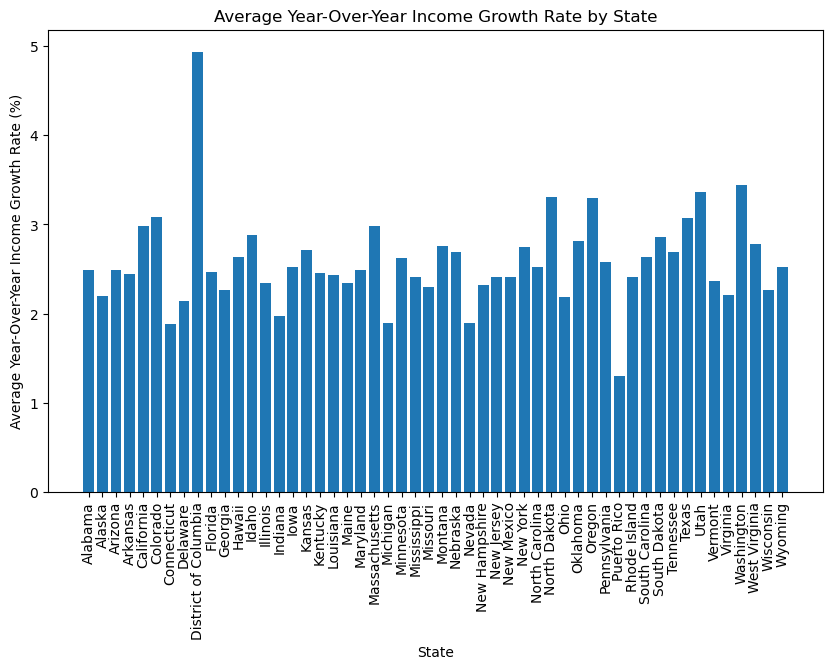

In [36]:
import matplotlib.pyplot as plt

# Sort the DataFrame by name and year
df_sorted = df.sort_values(['name', 'year'])

# Group the DataFrame by the 'name' column and calculate the percent change in income
df_sorted['income_growth_rate'] = df_sorted.groupby('name')['income'].pct_change()

# Calculate the average year-over-year income growth rate for each state
average_growth_rate = df_sorted.groupby('name')['income_growth_rate'].mean().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(average_growth_rate['name'], average_growth_rate['income_growth_rate'] * 100)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Average Year-Over-Year Income Growth Rate (%)')
plt.title('Average Year-Over-Year Income Growth Rate by State')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named df
df['income'] = df['income'].astype(float)
df['year'] = df['year'].astype(int)

# Group by state and calculate the average annual growth rate
df = df.sort_values(['name', 'year'])
df['income_growth'] = df.groupby('name')['income'].pct_change() + 1
df = df.groupby('name')['income_growth'].agg('mean') - 1

# Create a bar chart
df.sort_values().plot(kind='barh', figsize=(10, 20), color='skyblue')

plt.title('Average Year-Over-Year Income Growth Rate by State')
plt.xlabel('Average Year-Over-Year Growth Rate')
plt.ylabel('State')

plt.show()
'''
This Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.
'''

## Close Database Connection

In [33]:
#run the folloiwng code if the connection is not closed

cur.close()wha
conn.close()